In [1]:
def f(x):
    return x * 3  + x **2

In [4]:
f(8)

88

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
h = 0.0001
x = 3
(f(x+h) - f(x))/h

9.000100000022826

In [5]:
a = 2
b = -3
c = 10.0


d = a*b + c
print(d)

4.0


In [6]:
h = 0.0001
d1 = a*b + c
b +=h
d2 = a*b + c


print('slope', (d2 -d1)/h)

# All correct for now.

slope 2.0000000000042206


In [28]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad # Havn't understood this part yet ???
        out._backward = _backward

        return out

    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward


        return out
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(7.0, label = 'c')
d = a * b; d.label = 'd'
e = c * d; e.label = 'e'
e


Value(data=-42.0)

In [8]:
b.grad = 2.0

In [29]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


Right now we can do multiplicaton and addition, but not much else yet.

Now we will learn to calculate the derivatives. 30:50

In [10]:
def lol():

    hbig = Value(10000)
    hsmall = Value(0.0001)

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(6.0, label = 'c')
    d = Value(-9, label= 'e')
    e1 = a*b*c + d
    m = Value(-1)

    enormal = e1 * m; enormal.label = 'enormal'

    a = Value(2.0, label = 'a') 
    b = Value(-3.0, label = 'b')
    c = Value(6.0 + 0.0001, label = 'c')
    d = Value(-9, label= 'e')
    e2 = a*b*c + d
    
    
    
    r = (e2 + enormal) * hbig

    print(r)


    #Worked I did backpropagation correctly in this small model, the derivative -3.00000000 is correct.

In [11]:
lol()

Value(data=-5.9999999999860165)


In [12]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(7.0, label = 'c')
d = a * b; d.label = 'd'
e = c * d; e.label = 'e'

In [13]:
def lol2():

    h = 0.001

    a = Value(2.0,  label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(7.0+h,  label = 'c')
    d = a * b;  d.label = 'd'
    e = c * d;  e.label = 'e'

    e1 = e.data


    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(7.0, label = 'c')
    d = a * b; d.label = 'd'
    e = c * d; e.label = 'e'

    e2 = e.data
    
    
    
    r = (e1 - e2)/h

    print(r)

In [14]:
lol2()

-6.000000000000227


In [15]:
e.grad = 1

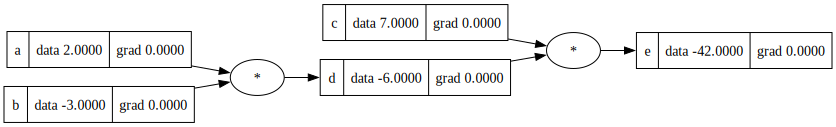

In [32]:
draw_dot(e)

45 minuetse

In [33]:
o.grad = 1.0


In [34]:
o._backward()

AttributeError: 'Value' object has no attribute '_backward'

In [17]:
a.grad = -21
b.grad = 14
c.grad = -6
d.grad = 7
e.grad = 1

In [18]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad


d = a * b;  d.label = 'd'
e = c * d;  e.label = 'e'


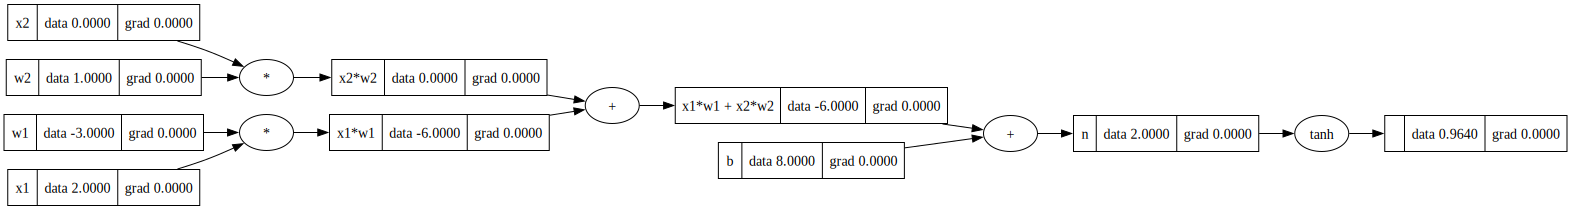

In [23]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(8, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

draw_dot(o)

In [20]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'